
# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

In [4]:
train.isnull()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False
889,False,False,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:>

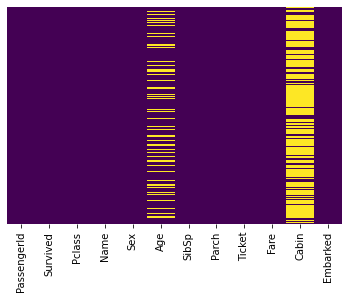

In [5]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

<AxesSubplot:xlabel='Survived', ylabel='count'>

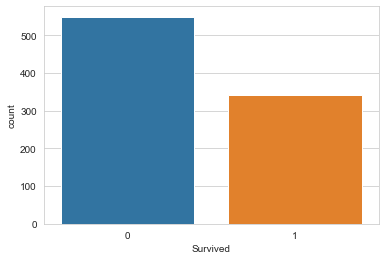

In [6]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train)

<AxesSubplot:xlabel='Survived', ylabel='count'>

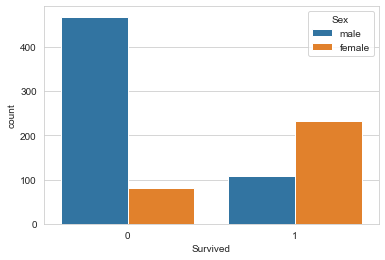

In [7]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train)

<AxesSubplot:xlabel='Survived', ylabel='count'>

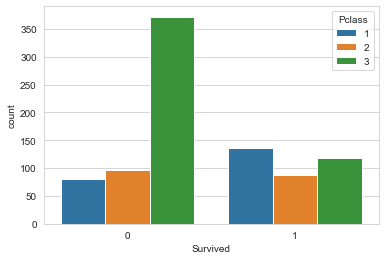

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train)

/tmp/ipykernel_22412/2002818437.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=40)


<AxesSubplot:xlabel='Age'>

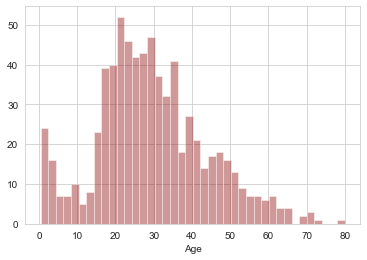

In [9]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=40)

In [10]:
train['Age'].dropna()

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
885    39.0
886    27.0
887    19.0
889    26.0
890    32.0
Name: Age, Length: 714, dtype: float64

<AxesSubplot:>

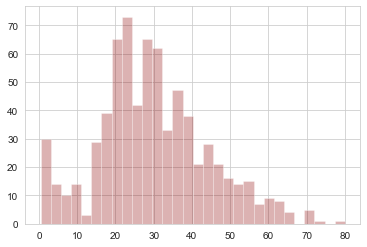

In [11]:
train['Age'].hist(bins=30,color='darkred',alpha=0.3)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

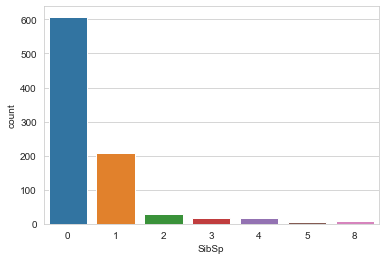

In [12]:
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

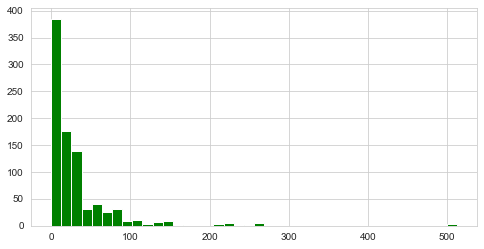

In [13]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

____
### Cufflinks for plots
___
 Let's take a quick moment to show an example of cufflinks!

In [14]:
import cufflinks as cf
cf.go_offline()

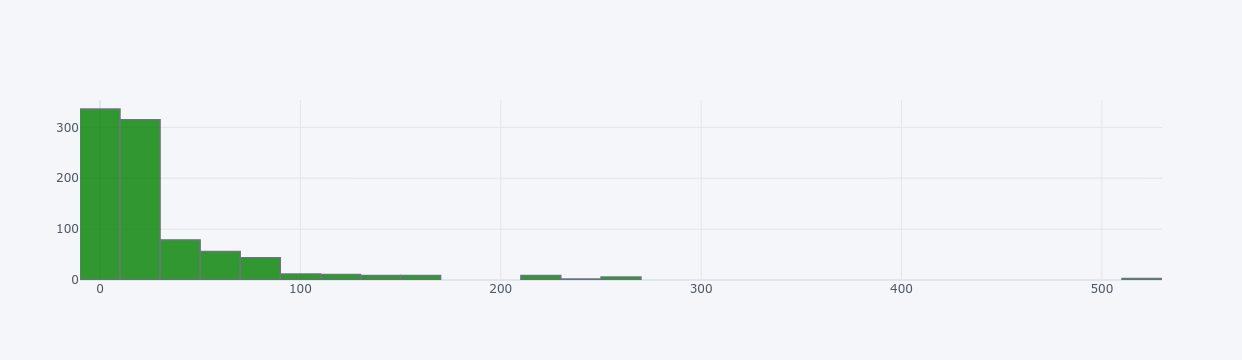

In [15]:
train['Fare'].iplot(kind='hist',bins=30,color='green')

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

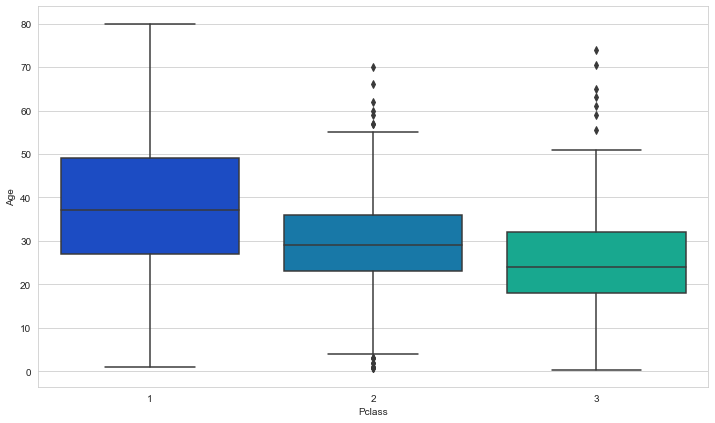

In [16]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [17]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [18]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

Now let's check that heat map again!

<AxesSubplot:>

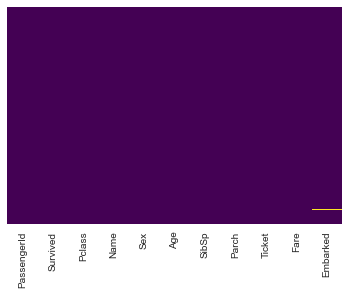

In [22]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [20]:
train.drop('Cabin',axis=1,inplace=True)

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [29]:
train.dropna(inplace=True)

In [30]:
train.notna().value_counts()

PassengerId  Survived  Pclass  Name  Sex   Age   SibSp  Parch  Ticket  Fare  Embarked
True         True      True    True  True  True  True   True   True    True  True        889
dtype: int64

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [36]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [34]:
pd.get_dummies(train['Embarked']).head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [37]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [38]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [39]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [40]:
train = pd.concat([train,sex,embark],axis=1)

In [41]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [42]:
train.drop('Survived',axis=1).head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,3,22.0,1,0,7.2500,1,0,1
1,2,1,38.0,1,0,71.2833,0,0,0
2,3,3,26.0,0,0,7.9250,0,0,1
3,4,1,35.0,1,0,53.1000,0,0,1
4,5,3,35.0,0,0,8.0500,1,0,1


In [43]:
train['Survived'].head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [47]:
from sklearn.linear_model import LogisticRegression

In [52]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/home/kishor/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [53]:
predictions = logmodel.predict(X_test)

In [54]:
from sklearn.metrics import confusion_matrix


In [55]:

accuracy=confusion_matrix(y_test,predictions)

In [56]:
accuracy

array([[149,  14],
       [ 39,  65]])

In [57]:
from sklearn.metrics import accuracy_score

In [58]:
accuracy=accuracy_score(y_test,predictions)
accuracy

0.8014981273408239

In [59]:
predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1])

Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [60]:
from sklearn.metrics import classification_report

In [61]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       163
           1       0.82      0.62      0.71       104

    accuracy                           0.80       267
   macro avg       0.81      0.77      0.78       267
weighted avg       0.80      0.80      0.80       267

